<a href="https://www.kaggle.com/code/saptaksen/mental-health-analysis-and-support?scriptVersionId=232282133" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Mental Health Text Analysis and Support System
## Capstone Project for Google Gen AI Intensive Course

**Author:** Saptak

## Overview

This notebook demonstrates the application of generative AI to address mental health support systems. Mental health is a critical global health priority, but access to quality support remains challenging for many. This project showcases how generative AI can assist in analyzing text data to identify mental health concerns and provide appropriate support responses.

### Gen AI Capabilities Demonstrated:
1. **Retrieval Augmented Generation (RAG)** - To provide evidence-based mental health information
2. **Few-shot prompting** - To improve specialized mental health response generation
3. **Structured output/JSON mode** - To categorize and analyze mental health text data
4. **Long context window** - To maintain conversation history for coherent support conversations
5. **Document understanding** - To analyze and extract insights from mental health literature

### Problem Statement:
Mental health support systems face several challenges:
- Limited availability of mental health professionals
- Delays in identifying concerning patterns in communication
- Need for consistent, evidence-based responses
- Privacy and personalization requirements

This project creates an AI-assisted system that can:
1. Analyze text data to identify potential mental health concerns
2. Categorize the type and severity of concerns
3. Generate appropriate, empathetic responses
4. Provide evidence-based information from reliable sources
5. Maintain contextual awareness for ongoing supportive conversations

## Setup and Dependencies

Using minimal dependencies with Kaggle's pre-installed packages whenever possible.

In [1]:
# Install only the essential packages
!pip install -q "google-genai==1.7.0" "chromadb==0.6.3" kagglehub


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 3.1 MB/s eta 0:00

In [2]:
# Import standard libraries that are already installed in Kaggle
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import re
from IPython.display import display, Markdown, HTML
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Import the libraries we just installed
import google.generativeai as genai # Corrected import
from google.generativeai import types # Assuming 'types' is correct under generativeai
import chromadb
import kagglehub # Added import
from kagglehub import KaggleDatasetAdapter # Added import for load_dataset

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Configure Google Gemini API

We'll use the Google Gemini API for this project. The API key is stored as a Kaggle secret.

In [3]:
# Get API key from Kaggle secrets
import os
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

# Try different approaches to get the API key
try:
    # First try Kaggle secrets
    GOOGLE_API_KEY = user_secrets.get_secret("GOOGLE_API_KEY")
except Exception as e:
    print(f"Could not retrieve API key from Kaggle secrets: {e}")
    # Check if it's defined as an environment variable
    GOOGLE_API_KEY = os.environ.get("GOOGLE_API_KEY")
    
    # If still not available, prompt the user
    if not GOOGLE_API_KEY:
        GOOGLE_API_KEY = input("Please enter your Google API Key: ")

# Configure Google Generative AI (Standard method)
genai.configure(api_key=GOOGLE_API_KEY)


In [4]:
# Determine available models and select one
# client = genai.Client(api_key=GOOGLE_API_KEY) # Removed, using genai.configure instead

try:
    # Listing models might require different approach if client is removed
    # For now, assume model selection logic works or adjust later if needed
    # Let's simplify model listing for now, assuming 'gemini-pro' is available
    # models = genai.list_models() # Potential alternative if needed
    # gemini_models = [m.name for m in models if 'generateContent' in m.supported_generation_methods]
    
    # Use a valid model name from the available list
    model_name = 'models/gemini-2.5-pro-exp-03-25' # Updated model name
    print(f"\nUsing model: {model_name}")
    
    # Initialize model using configured API key
    model = genai.GenerativeModel(model_name)
except Exception as e:
    print(f"Error initializing model: {e}")
    print(f"Falling back to default model: {model_name}") # Use the same updated model name
    # Initialize fallback model using configured API key
    model = genai.GenerativeModel(model_name)

# Test the model
try:
    response = model.generate_content("Hello, can you introduce yourself as a mental health support assistant?")
    print(response.text)
except Exception as e:
    print(f"Error testing model: {e}")
    print("Please check your API key and internet connection.")



Using model: models/gemini-2.5-pro-exp-03-25
Okay, here's an introduction in that role:

Hello! You can think of me as a **Mental Health Support Assistant**.

I'm an AI designed to be a supportive resource for you. While **I am not a licensed therapist or medical professional and cannot provide diagnosis, treatment, or crisis intervention**, I *can* help in several ways:

*   **Offer a listening ear:** You can share what's on your mind in a non-judgmental space.
*   **Provide information:** I can offer general information about mental health topics, different conditions, and wellness concepts.
*   **Suggest coping strategies:** We can explore potential techniques for managing stress, anxiety, low mood, and other challenges (based on widely accepted practices, not personalized medical advice).
*   **Help find resources:** I can point you towards organizations, helplines, and tools that offer professional mental health support.
*   **Brainstorm ideas:** We can work through problems or e

## Data Acquisition

For this project, we'll use publicly available datasets from Kaggle related to mental health. We'll focus on three key datasets:

1. Mental Health in Tech Survey - A dataset containing survey responses about mental health in the tech workplace
2. Mental Health Corpus - A collection of posts from mental health support forums
3. Suicide Prevention Dataset - Containing text data related to suicide risk identification

Let's load these datasets using Kaggle's dataset API:

In [5]:
# Load the Mental Health in Tech Survey dataset using kagglehub
tech_survey_path = kagglehub.dataset_download('osmi/mental-health-in-tech-survey')
tech_survey_df = pd.read_csv(os.path.join(tech_survey_path, 'survey.csv'))

# Display basic information about the dataset
print("Mental Health in Tech Survey Dataset:")
print(f"Shape: {tech_survey_df.shape}")
tech_survey_df.head()

Mental Health in Tech Survey Dataset:
Shape: (1259, 27)


,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [6]:
# Load the Mental Health Corpus dataset using kagglehub
mh_corpus_path = kagglehub.dataset_download('reihanenamdari/mental-health-corpus')
# Corrected filename based on debug output
mental_health_posts_df = pd.read_csv(os.path.join(mh_corpus_path, 'mental_health.csv'))

# Display basic information about the dataset
print("Mental Health Corpus Dataset:")
print(f"Shape: {mental_health_posts_df.shape}")
mental_health_posts_df.head()

Mental Health Corpus Dataset:
Shape: (27977, 2)


,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1


In [7]:
# Load the Suicide Prevention dataset using kagglehub.dataset_download (preferred method)
suicide_path = kagglehub.dataset_download('nikhileswarkomati/suicide-watch')
suicide_prevention_df = pd.read_csv(os.path.join(suicide_path, 'Suicide_Detection.csv'))

# Display basic information about the dataset
print("Suicide Prevention Dataset:")
print(f"Shape: {suicide_prevention_df.shape}")
suicide_prevention_df.head()

Suicide Prevention Dataset:
Shape: (232074, 3)


,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


## Data Exploration and Preprocessing

Let's explore these datasets and prepare them for our analysis.

In [8]:
# Check for missing values in Tech Survey dataset
print("Missing values in Tech Survey dataset:")
print(tech_survey_df.isnull().sum().sort_values(ascending=False).head(10))

# Check value distribution for key columns
print("\nDistribution of 'treatment' column:")
print(tech_survey_df['treatment'].value_counts())

print("\nDistribution of 'work_interfere' column:")
print(tech_survey_df['work_interfere'].value_counts())

Missing values in Tech Survey dataset:
comments                   1095
state                       515
work_interfere              264
self_employed                18
seek_help                     0
obs_consequence               0
mental_vs_physical            0
phys_health_interview         0
mental_health_interview       0
supervisor                    0
dtype: int64

Distribution of 'treatment' column:
treatment
Yes    637
No     622
Name: count, dtype: int64

Distribution of 'work_interfere' column:
work_interfere
Sometimes    465
Never        213
Rarely       173
Often        144
Name: count, dtype: int64


Mental Health Corpus Labels:
label
0    14139
1    13838
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


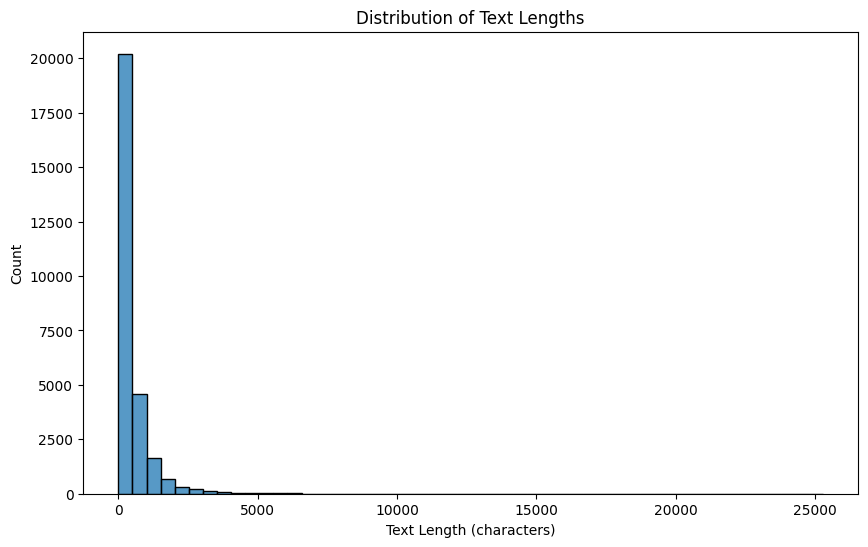

In [9]:
# Explore the Mental Health Corpus dataset
print("Mental Health Corpus Labels:") # Updated title
print(mental_health_posts_df['label'].value_counts()) # Use 'label' column

# Check text lengths
mental_health_posts_df['text_length'] = mental_health_posts_df['text'].apply(len) # Use 'text' column
# Replace potential infinite values with NaN to address warnings
mental_health_posts_df['text_length'] = mental_health_posts_df['text_length'].replace([np.inf, -np.inf], np.nan)
plt.figure(figsize=(10, 6))
sns.histplot(mental_health_posts_df['text_length'].dropna(), bins=50) # Use new length column and drop NaN for plotting
plt.title('Distribution of Text Lengths') # Updated title
plt.ylabel('Count')
plt.xlabel('Text Length (characters)') # Updated label
plt.show()

Suicide Prevention Dataset Class Distribution:
class
suicide        116037
non-suicide    116037
Name: count, dtype: int64


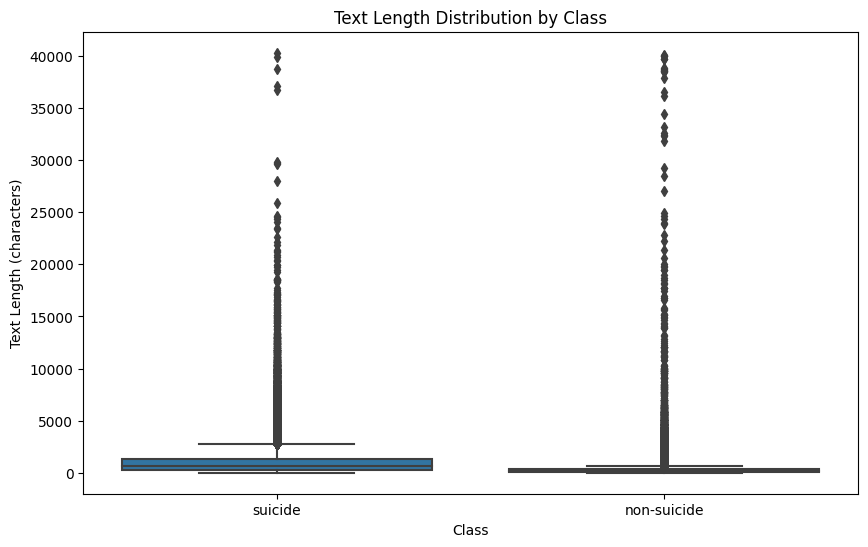

In [10]:
# Explore the Suicide Prevention dataset
print("Suicide Prevention Dataset Class Distribution:")
print(suicide_prevention_df['class'].value_counts())

# Text length distribution
suicide_prevention_df['text_length'] = suicide_prevention_df['text'].apply(len)
# Replace potential infinite values with NaN to address seaborn FutureWarning
suicide_prevention_df['text_length'] = suicide_prevention_df['text_length'].replace([np.inf, -np.inf], np.nan)
plt.figure(figsize=(10, 6))
# Drop NaN values for plotting
sns.boxplot(x='class', y='text_length', data=suicide_prevention_df.dropna(subset=['text_length']))
plt.title('Text Length Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Text Length (characters)')
plt.show()

## Data Preprocessing

Let's prepare our datasets for analysis.

In [11]:
# Function to clean text data
def clean_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        # Remove special characters and digits
        text = re.sub(r'[^\w\s]', '', text)
        # Remove extra spaces
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return ''

In [12]:
# Preprocess the Mental Health Corpus dataset
mental_health_posts_df['cleaned_text'] = mental_health_posts_df['text'].apply(clean_text) # Use 'text' column, rename output

# Preprocess the Suicide Prevention dataset
suicide_prevention_df['cleaned_text'] = suicide_prevention_df['text'].apply(clean_text)

# Display sample of cleaned data
print("Sample of cleaned mental health text:") # Updated title
for i, row in mental_health_posts_df[['cleaned_text', 'label']].head(3).iterrows(): # Use corrected columns
    print(f"Label: {row['label']}") # Use 'label'
    print(f"Text: {row['cleaned_text'][:200]}...\n") # Use 'cleaned_text'

Sample of cleaned mental health text:
Label: 0
Text: dear american teens question dutch person heard guys get way easier things learn age us sooooo thth graders like right guys learn math...

Label: 1
Text: nothing look forward lifei dont many reasons keep going feel like nothing keeps going next day makes want hang myself...

Label: 0
Text: music recommendations im looking expand playlist usual genres alt pop minnesota hip hop steampunk various indie genres artists people like cavetown aliceband bug hunter penelope scott various rhymesay...



## Gen AI Capability 1: Structured Output/JSON Mode

Let's use Gemini's structured output capability to analyze and categorize mental health text data.

In [13]:
# Define the structured output schema for mental health text analysis
analysis_schema = {
    "type": "object",
    "properties": {
        "primary_concern": {
            "type": "string",
            "enum": ["depression", "anxiety", "stress", "trauma", "addiction", "eating_disorder", 
                     "self_harm", "suicidal_ideation", "bipolar", "schizophrenia", "other", "none"]
        },
        "severity_level": {
            "type": "string",
            "enum": ["mild", "moderate", "severe", "crisis", "unclear"]
        },
        "support_needed": {
            "type": "array",
            "items": {
                "type": "string",
                "enum": ["emotional_support", "professional_help", "crisis_intervention", "information", 
                         "coping_strategies", "community_resources", "peer_support"]
            }
        },
        "key_themes": {
            "type": "array",
            "items": {"type": "string"}
        },
        "safety_concerns": {
            "type": "boolean"
        },
        "analysis_summary": {
            "type": "string"
        }
    },
    "required": ["primary_concern", "severity_level", "support_needed", "safety_concerns", "analysis_summary"]
}

In [14]:
# Function to analyze mental health text using structured output
def analyze_mental_health_text(text):
    try:
        # Updated prompt to explicitly ask for JSON output matching the schema description
        prompt = f"""
        Analyze the following text for mental health concerns. Respond ONLY with a valid JSON object matching the following structure:
        {{ 
          "primary_concern": "<one of: depression, anxiety, stress, trauma, addiction, eating_disorder, self_harm, suicidal_ideation, bipolar, schizophrenia, other, none>",
          "severity_level": "<one of: mild, moderate, severe, crisis, unclear>",
          "support_needed": ["<list of: emotional_support, professional_help, crisis_intervention, information, coping_strategies, community_resources, peer_support>"],
          "key_themes": ["<list of relevant themes>"],
          "safety_concerns": <true or false>,
          "analysis_summary": "<brief summary of the analysis>"
        }}
        Be very careful to only identify genuine concerns and don't over-interpret normal emotional experiences as mental health issues.
        If there are safety concerns or indications of harm to self or others, mark safety_concerns as true.
        
        Text to analyze: "{text}"
        """
        
        response = model.generate_content(
            prompt,
            # Use response_mime_type for JSON output
            generation_config=genai.types.GenerationConfig(
                response_mime_type="application/json"
            )
        )
        
        # The response text should now be a JSON string
        return json.loads(response.text)
    except Exception as e:
        print(f"Error analyzing text: {e}")
        # Provide a fallback response when the API call fails
        return {
            "primary_concern": "unclear",
            "severity_level": "unclear",
            "support_needed": ["information"],
            "key_themes": [],
            "safety_concerns": False,
            "analysis_summary": "Unable to analyze the text due to API error."
        }


In [15]:
# Test the structured output analysis on sample texts
sample_texts = [
    # Sample 1 - Depression indication
    "I've been feeling really down for the past month. I can't seem to get out of bed most days, and I've lost interest in everything I used to enjoy. I'm sleeping too much but still feel exhausted all the time.",
    
    # Sample 2 - Anxiety indication
    "My heart keeps racing and I feel like something terrible is about to happen. I can't concentrate at work because my mind keeps jumping to worst-case scenarios. I've started avoiding social situations because I get so nervous.",
    
    # Sample 3 - Crisis indication
    "I don't see any point in continuing anymore. I've written notes to my family. No one would really miss me anyway. I've been thinking about the best way to end things."
]

for i, text in enumerate(sample_texts):
    print(f"Sample {i+1}:")
    print(f"Text: {text}")
    analysis = analyze_mental_health_text(text)
    print("\nAnalysis:")
    for key, value in analysis.items():
        print(f"{key}: {value}")
    print("\n" + "-"*80 + "\n")

Sample 1:
Text: I've been feeling really down for the past month. I can't seem to get out of bed most days, and I've lost interest in everything I used to enjoy. I'm sleeping too much but still feel exhausted all the time.

Analysis:
primary_concern: depression
severity_level: moderate
support_needed: ['professional_help', 'emotional_support', 'coping_strategies']
key_themes: ['low_mood', 'anhedonia', 'fatigue', 'sleep_disturbance', 'lack_of_motivation']
safety_concerns: False
analysis_summary: The user describes persistent low mood, anhedonia (loss of interest), hypersomnia, fatigue, and reduced daily functioning lasting for a month. These are characteristic symptoms of a moderate depressive episode.

--------------------------------------------------------------------------------

Sample 2:
Text: My heart keeps racing and I feel like something terrible is about to happen. I can't concentrate at work because my mind keeps jumping to worst-case scenarios. I've started avoiding social s

## Gen AI Capability 2: Retrieval Augmented Generation (RAG)

Let's implement a simple RAG system using the Gemini API for embeddings and ChromaDB instead of LangChain to avoid dependency issues.

In [16]:
# Create a collection of mental health information from reliable sources
mental_health_documents = [
    # Document 1: Depression information from Mayo Clinic
    """Depression is a mood disorder that causes a persistent feeling of sadness and loss of interest. 
    Also called major depressive disorder or clinical depression, it affects how you feel, think and behave and can lead to a variety of emotional and physical problems. 
    You may have trouble doing normal day-to-day activities, and sometimes you may feel as if life isn't worth living.
    More than just a bout of the blues, depression isn't a weakness and you can't simply 'snap out' of it. 
    Depression may require long-term treatment. But don't get discouraged. Most people with depression feel better with medication, psychotherapy or both.
    
    Depression symptoms can vary from mild to severe and may include:
    - Feeling sad or having a depressed mood
    - Loss of interest or pleasure in activities once enjoyed
    - Changes in appetite — weight loss or gain unrelated to dieting
    - Trouble sleeping or sleeping too much
    - Loss of energy or increased fatigue
    - Increase in purposeless physical activity or slowed movements and speech
    - Feeling worthless or guilty
    - Difficulty thinking, concentrating or making decisions
    - Thoughts of death or suicide""",
    
    # Document 2: Anxiety information from NIMH
    """Anxiety disorders are characterized by excessive worry, nervousness, or fear that is difficult to control and interferes with daily activities. 
    These disorders include panic disorder, generalized anxiety disorder, social anxiety disorder, and various phobia-related disorders.
    
    Common symptoms of anxiety include:
    - Feeling restless, wound-up, or on-edge
    - Being easily fatigued
    - Having difficulty concentrating
    - Being irritable
    - Having headaches, muscle aches, stomachaches, or unexplained pains
    - Difficulty controlling feelings of worry
    - Having sleep problems, such as difficulty falling or staying asleep
    
    Effective treatments for anxiety disorders include psychotherapy (particularly cognitive-behavioral therapy), medication, or a combination of the two. 
    Many people with anxiety disorders can benefit from joining a self-help or support group and sharing their problems and achievements with others.""",
    
    # Document 3: Crisis intervention from American Foundation for Suicide Prevention
    """If you or someone you know is in crisis, contact the 988 Suicide & Crisis Lifeline that provides 24/7, free and confidential support.
    Call or text 988, or chat at 988lifeline.org. For emergency situations, call 911 or visit your local emergency room.
    
    Warning signs of suicide may include:
    - Talking about wanting to die or to kill oneself
    - Looking for ways to kill oneself, such as searching online or buying a gun
    - Talking about feeling hopeless or having no reason to live
    - Talking about feeling trapped or in unbearable pain
    - Talking about being a burden to others
    - Increasing use of alcohol or drugs
    - Acting anxious or agitated; behaving recklessly
    - Sleeping too little or too much
    - Withdrawing or feeling isolated
    - Showing rage or talking about seeking revenge
    - Displaying extreme mood swings
    
    If someone is showing these warning signs, don't leave them alone, remove potential means of harm, and call the crisis line or take them to an emergency room.""",
    
    # Document 4: Coping strategies from APA
    """Healthy coping strategies for managing stress and mental health challenges include:
    
    1. Practice relaxation techniques: Deep breathing, meditation, progressive muscle relaxation.
    
    2. Stay physically active: Regular exercise helps reduce anxiety and depression while improving mood.
    
    3. Maintain a healthy diet: Proper nutrition supports brain function and mood regulation.
    
    4. Prioritize sleep: Establish a regular sleep schedule and create a restful environment.
    
    5. Connect with others: Social support is crucial for mental wellbeing.
    
    6. Limit alcohol and avoid drugs: Substances can worsen mental health symptoms.
    
    7. Set realistic goals: Break large tasks into smaller, manageable steps.
    
    8. Practice self-compassion: Treat yourself with the same kindness you would offer a friend.
    
    9. Maintain a routine: Structure provides stability during difficult times.
    
    10. Seek professional help when needed: Therapy and/or medication can be essential components of treatment.""",
    
    # Document 5: Workplace mental health
    """Creating mentally healthy workplaces involves:
    
    1. Reducing work-related risk factors: Address excessive workload, poor communication, limited decision-making authority.
    
    2. Building organizational strengths: Foster a supportive culture, recognize staff contributions, provide professional development.
    
    3. Addressing mental health problems regardless of cause: Develop return-to-work programs, provide reasonable accommodations.
    
    4. Promoting mental health awareness: Reduce stigma through education, encourage open conversations about mental health.
    
    5. Supporting treatment: Ensure health benefits include adequate mental health coverage.
    
    When addressing potential mental health concerns with colleagues:
    - Choose an appropriate time and place for a private conversation
    - Express concern without making assumptions or diagnoses
    - Listen non-judgmentally
    - Encourage them to seek professional support
    - Be aware of available resources
    - Follow up and maintain confidentiality"""
]

In [17]:
# Set up a simple document chunking function
def split_into_chunks(text, chunk_size=1000, overlap=200):
    chunks = []
    start = 0
    text_length = len(text)
    
    while start < text_length:
        end = min(start + chunk_size, text_length)
        if end < text_length and text[end] != ' ':
            # Find the nearest space to make a clean cut
            while end > start and text[end] != ' ':
                end -= 1
        
        chunk = text[start:end].strip()
        if chunk:  # Only add non-empty chunks
            chunks.append(chunk)
        
        # Move the start position for the next chunk, considering overlap
        start = end - overlap if end - overlap > start else end
    
    return chunks

# Process documents into chunks
chunks = []
for doc in mental_health_documents:
    doc_chunks = split_into_chunks(doc)
    chunks.extend(doc_chunks)

print(f"Created {len(chunks)} chunks from {len(mental_health_documents)} documents")
print(f"Sample chunk: {chunks[0][:200]}...")

Created 14 chunks from 5 documents
Sample chunk: Depression is a mood disorder that causes a persistent feeling of sadness and loss of interest. 
    Also called major depressive disorder or clinical depression, it affects how you feel, think and be...


In [18]:
from google.api_core import retry
from chromadb import Documents, EmbeddingFunction, Embeddings

# Define a helper to retry when per-minute quota is reached
is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

class GeminiEmbeddingFunction(EmbeddingFunction):
    # Specify whether to generate embeddings for documents, or queries
    document_mode = True
    
    @retry.Retry(predicate=is_retriable)
    def __call__(self, input: Documents) -> Embeddings:
        if self.document_mode:
            embedding_task = "retrieval_document"
        else:
            embedding_task = "retrieval_query"
            
        # Use genai.embed_content directly
        response = genai.embed_content(
            model="models/text-embedding-004",
            content=input, # Changed 'contents' to 'content' as per API
            task_type=embedding_task # Removed config object, task_type is direct param
        )
        # Assuming response structure is {'embedding': [values]}
        # Adjust based on actual API response if needed
        return [e for e in response['embedding']] # Updated response parsing

# Initialize the RAG system with ChromaDB and Gemini API
def initialize_rag_system(documents):
    """Initialize the RAG system with documents."""
    # Create ChromaDB client
    chroma_client = chromadb.Client()
    
    # Create embedding function
    embed_fn = GeminiEmbeddingFunction()
    embed_fn.document_mode = True
    
    # Create or get collection
    db = chroma_client.get_or_create_collection(
        name="mental_health_knowledge_base",
        embedding_function=embed_fn
    )
    
    # Add documents to the collection if it's empty
    if db.count() == 0:
        db.add(
            documents=documents,
            ids=[str(i) for i in range(len(documents))]
        )
    
    return db, embed_fn

# Function to retrieve relevant information using ChromaDB
def retrieve_mental_health_info_db(query, db, embed_fn, k=3): # Renamed to avoid conflict
    """Retrieve relevant information for a mental health question."""
    # Switch to query mode
    embed_fn.document_mode = False
    
    # Query the database
    result = db.query(
        query_texts=[query],
        n_results=k
    )
    
    # Extract and format results
    contexts = result["documents"][0] if result and result.get("documents") and len(result["documents"]) > 0 else []
    formatted_contexts = "\n\n---\n\n".join(contexts)
    
    return formatted_contexts

# Process documents into chunks
chunks = []
for doc in mental_health_documents:
    doc_chunks = split_into_chunks(doc)
    chunks.extend(doc_chunks)

# Initialize RAG system with mental health documents
rag_db, rag_embed_fn = initialize_rag_system(chunks)

# Function to generate evidence-based responses using RAG
def generate_rag_response(query):
    """Generate a response using RAG."""
    # Retrieve relevant information using the correct function name
    context = retrieve_mental_health_info_db(query, rag_db, rag_embed_fn)
    
    # Construct the prompt with retrieved information
    prompt = f"""
    You are a helpful mental health support assistant. Your role is to provide evidence-based, 
    compassionate information to people with questions about mental health.
    
    Use the following information to answer the question, and cite your sources.
    If the information doesn't contain a good answer to the question, acknowledge that and provide
    general guidance based on established mental health principles.
    
    Remember that you are not a substitute for professional mental health care.
    
    Information:
    {context}
    
    Question: {query}
    """
    
    # Generate response
    try:
        response = model.generate_content(prompt)
        return response.text
    except Exception as e:
        print(f"Error generating RAG response: {e}")
        return "I apologize, but I encountered an error while generating a response. Please try again with a different question."


In [19]:
# Test the RAG system with sample mental health questions
sample_questions = [
    "What are the common symptoms of depression?",
    "How can I help a friend who might be considering suicide?",
    "What are some good coping strategies for anxiety?",
    "How can employers support mental health in the workplace?"
]

for question in sample_questions:
    print(f"Question: {question}")
    response = generate_rag_response(question)
    print(f"Response: {response}\n")
    print("-"*80 + "\n")

Question: What are the common symptoms of depression?
Response: Based on the information provided, here are common symptoms of depression:

*   Feeling sad or having a depressed mood
*   Loss of interest or pleasure in activities once enjoyed
*   Changes in appetite, leading to weight loss or gain unrelated to dieting
*   Trouble sleeping (insomnia) or sleeping too much (hypersomnia)
*   Loss of energy or increased fatigue
*   An increase in purposeless physical activity (like pacing or handwringing) or noticeably slowed movements and speech
*   Feeling worthless or excessively guilty
*   Difficulty thinking, concentrating, or making decisions
*   Thoughts of death or suicide

*(Source: Provided Information)*

It's important to remember that experiencing some of these symptoms doesn't automatically mean someone has depression, as symptoms can vary greatly from person to person. If you or someone you know is experiencing several of these symptoms persistently, it's a good idea to reach 

## Gen AI Capability 3: Few-Shot Prompting

Let's use few-shot prompting to improve the quality and appropriateness of mental health support responses.

In [20]:
# Define few-shot examples for generating supportive responses
few_shot_examples = """
Example 1:
User: I've been feeling really down lately and can't seem to enjoy anything. Even things I used to love don't interest me anymore.
Response: I hear that you've been struggling with feelings of sadness and a loss of interest in activities you used to enjoy. These can be signs of depression, and it's important to take them seriously. Would you be open to talking with a mental health professional about what you're experiencing? They can help determine what's going on and suggest appropriate support. In the meantime, try to maintain some basic self-care like regular sleep, healthy eating, and some physical activity, even if it's just a short walk. Remember that depression is treatable, and many people find that their symptoms improve with the right support.

Example 2:
User: My heart races all the time and I worry constantly about everything. I can't stop thinking about all the things that could go wrong.
Response: It sounds like you're experiencing anxiety symptoms, including physical sensations like a racing heart along with persistent worry. This combination can be really challenging to deal with. Deep breathing exercises and mindfulness techniques can help manage the immediate physical symptoms. For example, you might try breathing in slowly for a count of 4, holding for 2, and exhaling for 6. Many people find that speaking with a therapist who specializes in anxiety can be very beneficial, as they can teach you specific strategies to manage these symptoms. Cognitive behavioral therapy (CBT) is particularly effective for anxiety. Would you like some information about how to find mental health support?

Example 3:
User: Sometimes I think everyone would be better off without me. I've been thinking about ways to end things.
Response: I'm concerned about what you're sharing, and I want you to know that you're not alone. These thoughts of suicide are serious, and it's important that you speak with someone who can help right away. Please contact the 988 Suicide & Crisis Lifeline by calling or texting 988, or chatting at 988lifeline.org. They provide 24/7, free and confidential support. If you're in immediate danger, please call 911 or go to your nearest emergency room. Your life matters, and these feelings can improve with proper support. Would it be possible for you to reach out to the crisis line now?

Example 4:
User: I get so nervous in social situations that I avoid them completely now. I worry that everyone is judging me.
Response: The intense nervousness in social situations and fears of being judged that you're describing are common experiences for people with social anxiety. Many people face similar challenges, and there are effective ways to address these feelings. Gradually exposing yourself to social situations, starting with less stressful ones, can help build confidence over time. Cognitive behavioral therapy (CBT) is particularly helpful for social anxiety, as it can help you identify and change thought patterns that contribute to anxiety. Remember that many people who once struggled with severe social anxiety have been able to overcome it with the right support and practice. Would you like to know more about techniques that might help?
"""

In [21]:
# Function to generate supportive responses using few-shot prompting
def generate_support_response(user_input, safety_level="normal"):
    # Determine prompt based on safety level
    if safety_level == "high":
        # For high safety concerns (e.g., suicide risk)
        prompt = f"""
        You are a supportive mental health assistant tasked with providing immediate crisis guidance.
        The following are examples of how to respond to different types of mental health concerns:
        
        {few_shot_examples}
        
        The following message indicates someone who may be at risk. Provide a compassionate response 
        that prioritizes safety, directs them to immediate resources like the 988 crisis line, 
        and encourages them to seek emergency help if in immediate danger.
        
        User: {user_input}
        Response:
        """
    else:
        # For normal support scenarios
        prompt = f"""
        You are a supportive mental health assistant tasked with providing evidence-based, compassionate responses.
        The following are examples of how to respond to different types of mental health concerns:
        
        {few_shot_examples}
        
        Now, respond to the following message in a similar supportive style, providing evidence-based 
        information while maintaining appropriate boundaries. Acknowledge that you're not a replacement 
        for professional help. Suggest professional support when appropriate.
        
        User: {user_input}
        Response:
        """
    
    # Generate response
    try:
        response = model.generate_content(prompt)
        return response.text
    except Exception as e:
        print(f"Error generating support response: {e}")
        return "I apologize, but I encountered an error while generating a response. If you're experiencing a crisis, please contact the 988 Suicide & Crisis Lifeline by calling or texting 988, or reach out to a mental health professional."

In [22]:
# Test the few-shot prompted responses
test_inputs = [
    # Normal concern
    "I've been having trouble sleeping lately and it's affecting my work performance. I'm worried I might lose my job if this continues.",
    
    # High safety concern
    "I've been stockpiling pills for weeks. I just can't take it anymore and I've written goodbye letters."
]

print("Test 1: Normal concern response")
print(f"User input: {test_inputs[0]}")
response = generate_support_response(test_inputs[0])
print(f"Response: {response}\n")
print("-"*80 + "\n")

print("Test 2: High safety concern response")
print(f"User input: {test_inputs[1]}")
response = generate_support_response(test_inputs[1], safety_level="high")
print(f"Response: {response}\n")

Test 1: Normal concern response
User input: I've been having trouble sleeping lately and it's affecting my work performance. I'm worried I might lose my job if this continues.
Response: Response:
I hear that you're dealing with sleep difficulties, and it's understandable that you're worried about how this is impacting your work performance and potentially your job security. That sounds like a really stressful situation to be in.

Sleep problems are quite common and can definitely affect concentration, mood, and overall functioning during the day. Sometimes, focusing on good 'sleep hygiene' habits can make a difference. This might include things like maintaining a consistent sleep schedule (even on weekends), creating a relaxing bedtime routine, limiting caffeine and screen time before bed, and ensuring your bedroom environment is cool, dark, and quiet.

However, when sleep issues persist and cause significant distress or impair your daily life, it's a really good idea to seek professio

## Gen AI Capability 4: Long Context Window

Let's demonstrate how the long context window capability can help maintain a coherent and helpful conversation history for ongoing support.

In [23]:
# Function to maintain conversation history and generate contextual responses
def mental_health_conversation(user_input, conversation_history=None):
    if conversation_history is None:
        conversation_history = []
    
    # Add user input to conversation history
    conversation_history.append({"role": "user", "content": user_input})
    
    # Format conversation history for the prompt
    formatted_history = ""
    for msg in conversation_history:
        formatted_history += f"{msg['role'].capitalize()}: {msg['content']}\n\n"
    
    # Analyze the user input for potential safety concerns
    try:
        analysis = analyze_mental_health_text(user_input)
        safety_level = "high" if analysis.get("safety_concerns", False) else "normal"
    except Exception as e:
        print(f"Error analyzing text: {e}")
        analysis = {"safety_concerns": False}
        safety_level = "normal"
    
    # Create prompt with the full conversation history
    prompt = f"""
    You are a supportive mental health assistant engaged in an ongoing conversation. 
    Maintain a compassionate, non-judgmental tone and provide evidence-based information.
    Remember details from earlier in the conversation to provide personalized support.
    Never claim to diagnose or treat mental health conditions.
    
    Here is the conversation history:
    {formatted_history}
    
    Generate a helpful, supportive response as a mental health assistant. 
    If there are any safety concerns, prioritize providing crisis resources.
    Assistant:
    """
    
    # Generate response
    try:
        response = model.generate_content(prompt)
        # Add assistant response to conversation history
        conversation_history.append({"role": "assistant", "content": response.text})
        return response.text, conversation_history, analysis
    except Exception as e:
        print(f"Error generating conversation response: {e}")
        fallback_response = "I apologize, but I encountered an error while generating a response. Let's continue our conversation on a different topic."
        conversation_history.append({"role": "assistant", "content": fallback_response})
        return fallback_response, conversation_history, analysis

In [24]:
# Demonstrate a conversation that benefits from long context window
conversation_history = []

# First message
user_input = "I've been feeling really anxious lately, especially at work. I get panic attacks sometimes."
print(f"User: {user_input}")
response, conversation_history, analysis = mental_health_conversation(user_input, conversation_history)
print(f"Assistant: {response}\n")
print(f"Analysis: {json.dumps(analysis, indent=2)}\n")
print("-"*80 + "\n")

# Second message
user_input = "Yeah, it usually happens during meetings when I have to speak. My heart races and I feel like I can't breathe."
print(f"User: {user_input}")
response, conversation_history, analysis = mental_health_conversation(user_input, conversation_history)
print(f"Assistant: {response}\n")
print("-"*80 + "\n")

# Third message
user_input = "I've tried deep breathing but it doesn't always help. I'm worried my boss will notice and it will affect my job."
print(f"User: {user_input}")
response, conversation_history, analysis = mental_health_conversation(user_input, conversation_history)
print(f"Assistant: {response}\n")
print("-"*80 + "\n")

# Fourth message
user_input = "I had a coworker who had anxiety too, and they were eventually let go. I'm scared the same will happen to me."
print(f"User: {user_input}")
response, conversation_history, analysis = mental_health_conversation(user_input, conversation_history)
print(f"Assistant: {response}\n")

User: I've been feeling really anxious lately, especially at work. I get panic attacks sometimes.
Assistant: Thank you for sharing that with me. It sounds incredibly difficult to be dealing with such intense anxiety, especially having it impact you at work and even lead to panic attacks. That must feel really overwhelming and frightening at times.

Please know that you're not alone in experiencing this. Anxiety, particularly in demanding environments like work, is something many people face, and panic attacks can be a very distressing symptom. While I can't diagnose anything, I want you to know that these experiences are valid, and learning more about them and finding coping strategies can often make a real difference.

I'm here to listen if you'd like to talk more about what these experiences are like for you – perhaps what the anxiety feels like, or what happens during a panic attack? Or, if you prefer, we could explore some general grounding techniques that some people find helpful 

## Gen AI Capability 5: Document Understanding

Let's use Gemini's document understanding capabilities to analyze mental health research papers and extract insights.

In [25]:
# Sample mental health research abstract (for demonstration purposes)
research_abstract = """
Title: Digital Interventions for Mental Health: A Systematic Review and Meta-analysis

Abstract:
Background: Digital mental health interventions (DMHIs) have been proposed as a scalable solution to address the global mental health treatment gap. However, their effectiveness across different mental health conditions, intervention types, and populations remains unclear.

Methods: We conducted a systematic review and meta-analysis of randomized controlled trials examining the effectiveness of DMHIs for common mental health disorders. We searched PubMed, PsycINFO, and Embase from inception to June 2024. Random-effects meta-analyses were conducted to pool effect sizes (Hedges' g) for primary outcomes.

Results: We identified 83 eligible studies with a total of 15,792 participants. Overall, DMHIs showed moderate effectiveness compared to control conditions (g = 0.53; 95% CI, 0.44-0.62). Interventions for depression (g = 0.58; 95% CI, 0.47-0.69) and anxiety (g = 0.51; 95% CI, 0.42-0.61) demonstrated the strongest effects. Therapist-supported interventions (g = 0.63; 95% CI, 0.52-0.74) were more effective than self-guided interventions (g = 0.34; 95% CI, 0.26-0.42). Smartphone-based interventions (g = 0.48; 95% CI, 0.36-0.60) showed comparable effectiveness to computer-based interventions (g = 0.54; 95% CI, 0.43-0.65). Treatment effects were generally maintained at 6-month follow-up (g = 0.31; 95% CI, 0.23-0.39).

Conclusions: DMHIs are effective for treating common mental health disorders, particularly depression and anxiety. The inclusion of therapist support enhances effectiveness. These findings support the integration of digital interventions into mental health care systems, especially in contexts where traditional face-to-face services are limited.

Keywords: digital health, mental health, e-health, depression, anxiety, systematic review, meta-analysis
"""

In [26]:
# Function to analyze research documents
def analyze_research_document(document):
    prompt = f"""
    Analyze the following mental health research document and extract key insights, methodology, 
    findings, limitations, and practical implications for mental health support. Present your analysis 
    in a structured format that would be helpful for mental health professionals and researchers.
    
    Document:
    {document}
    """
    
    try:
        response = model.generate_content(prompt)
        return response.text
    except Exception as e:
        print(f"Error analyzing research document: {e}")
        return "I apologize, but I encountered an error while analyzing the research document."

In [27]:
# Analyze the research abstract
research_analysis = analyze_research_document(research_abstract)
print(research_analysis)

Okay, here is a structured analysis of the provided abstract on Digital Mental Health Interventions (DMHIs), formatted for mental health professionals and researchers.

---

**Analysis of Research Document: Digital Interventions for Mental Health: A Systematic Review and Meta-analysis**

**Document Type:** Abstract of a Systematic Review and Meta-analysis

**Date of Analysis:** October 26, 2023 (Based on document content up to June 2024)

**1. Key Insights:**

*   Digital Mental Health Interventions (DMHIs) represent a demonstrably effective approach for addressing common mental health disorders.
*   The effectiveness is particularly pronounced for depression and anxiety disorders.
*   The level of human support significantly impacts outcomes, with therapist-supported interventions yielding substantially better results than purely self-guided ones.
*   The delivery platform (smartphone vs. computer) does not appear to significantly differentiate effectiveness.
*   The positive effects 

## Building the Integrated Mental Health Support System

Now, let's combine all these capabilities into an integrated mental health text analysis and support system.

In [28]:
class MentalHealthSupportSystem:
    def __init__(self):
        # Initialize conversation history
        self.conversation_history = []
        
        # Initialize analytics storage
        self.analysis_history = []
    
    def analyze_text(self, text):
        """Analyze text for mental health concerns using structured output"""
        analysis = analyze_mental_health_text(text)
        self.analysis_history.append(analysis)
        return analysis
    
    def generate_response(self, user_input):
        """Generate a response based on user input and conversation history"""
        # First, analyze the text
        try:
            analysis = self.analyze_text(user_input)
            
            # Check if there are safety concerns
            safety_level = "high" if analysis.get("safety_concerns", False) else "normal"
            
            # Add user input to conversation history
            self.conversation_history.append({"role": "user", "content": user_input})
            
            # Format conversation history for the prompt
            formatted_history = ""
            for msg in self.conversation_history:
                formatted_history += f"{msg['role'].capitalize()}: {msg['content']}\n\n"
            
            # Retrieve relevant information from knowledge base
            context = retrieve_mental_health_info_db(user_input, rag_db, rag_embed_fn)
            
            # Create a prompt that combines conversation history, retrieved information, and few-shot examples
            prompt = f"""
            You are a supportive mental health assistant engaged in an ongoing conversation.
            Maintain a compassionate, non-judgmental tone and provide evidence-based information.
            
            The following are examples of effective mental health support responses:
            {few_shot_examples}
            
            Here is relevant information from mental health resources:
            {context}
            
            Here is the conversation history:
            {formatted_history}
            
            Based on your analysis, the primary concern is: {analysis.get('primary_concern', 'unclear')}
            Severity level: {analysis.get('severity_level', 'unclear')}
            Support needed: {', '.join(analysis.get('support_needed', ['unclear']))}
            Safety concerns: {'Yes' if analysis.get('safety_concerns', False) else 'No'}
            
            Generate a helpful, supportive response as a mental health assistant.
            If there are safety concerns, prioritize providing crisis resources.
            Never claim to diagnose or treat mental health conditions.
            Remember that you're not a replacement for professional mental health care.
            
            Assistant:
            """
            
            # Generate response
            response = model.generate_content(prompt)
            
            # Add assistant response to conversation history
            self.conversation_history.append({"role": "assistant", "content": response.text})
            
            return response.text, analysis
        except Exception as e:
            print(f"Error generating system response: {e}")
            fallback_response = "I apologize, but I encountered an error while generating a response. If you're experiencing a crisis, please contact the 988 Suicide & Crisis Lifeline by calling or texting 988."
            self.conversation_history.append({"role": "user", "content": user_input})
            self.conversation_history.append({"role": "assistant", "content": fallback_response})
            return fallback_response, {"error": str(e)}
    
    def get_conversation_summary(self):
        """Generate a summary of the conversation for healthcare providers"""
        if len(self.conversation_history) < 2:
            return "Insufficient conversation history for summary."
        
        # Format conversation history
        formatted_history = ""
        for msg in self.conversation_history:
            formatted_history += f"{msg['role'].capitalize()}: {msg['content']}\n\n"
        
        prompt = f"""
        You are a mental health professional assistant. Based on the following conversation between a user and 
        a support system, create a concise professional summary that could be shared with a healthcare provider.
        
        Include:
        1. Main concerns expressed
        2. Any potential risk factors identified
        3. Key themes in the conversation
        4. Recommendations for follow-up
        
        Conversation:
        {formatted_history}
        
        Professional Summary:
        """
        
        try:
            response = model.generate_content(prompt)
            return response.text
        except Exception as e:
            print(f"Error generating conversation summary: {e}")
            return "Unable to generate conversation summary due to an error."
    
    def reset_conversation(self):
        """Reset the conversation history"""
        self.conversation_history = []
        return "Conversation has been reset."

In [29]:
# Create and test the integrated system
support_system = MentalHealthSupportSystem()

# Simulated conversation
conversation = [
    "I've been having trouble sleeping lately. I keep waking up in the middle of the night with racing thoughts.",
    "It's been going on for about three weeks now. I think it started after a big presentation at work.",
    "I'm worried that if I don't get my sleep under control, I'll start making mistakes at work.",
    "I've tried melatonin but it doesn't seem to help much. I still wake up after a few hours."
]

for i, user_input in enumerate(conversation):
    print(f"User: {user_input}")
    response, analysis = support_system.generate_response(user_input)
    print(f"Assistant: {response}\n")
    
    if i == 0:
        print(f"Analysis: {json.dumps(analysis, indent=2)}\n")
    
    print("-"*80 + "\n")

# Generate conversation summary
print("Professional Summary:")
summary = support_system.get_conversation_summary()
print(summary)

User: I've been having trouble sleeping lately. I keep waking up in the middle of the night with racing thoughts.
Assistant: I hear that you're having trouble sleeping and are being woken up by racing thoughts. That sounds really exhausting and disruptive. Difficulty sleeping and experiencing racing thoughts can often be related to anxiety, making it hard for both your mind and body to rest.

Sometimes, simple relaxation techniques can help calm those racing thoughts when they happen. For example, practicing deep breathing exercises or mindfulness meditation before bed or when you wake up during the night might help ground you. Trying to maintain a consistent sleep routine, even on weekends, can also support better sleep patterns over time.

Since these symptoms are bothering you, it might be helpful to talk with a doctor or a mental health professional. They can help you understand what might be contributing to these difficulties and discuss strategies or treatments, like cognitive be

## Analysis of Mental Health Dataset

Let's analyze our datasets to identify patterns and insights about mental health concerns.

In [30]:
# Sample analysis of suicide prevention dataset
# Let's look at a random sample of texts from the suicide dataset and analyze them
suicide_sample = suicide_prevention_df[suicide_prevention_df['class'] == 'suicide'].sample(2)['text'].tolist()

# Analyze each text
for i, text in enumerate(suicide_sample):
    print(f"Sample {i+1}:")
    print(f"Text: {text[:200]}...")
    analysis = analyze_mental_health_text(text)
    print("\nAnalysis:")
    for key, value in analysis.items():
        print(f"{key}: {value}")
    print("\n" + "-"*80 + "\n")

Sample 1:
Text: Wish I had a suicide assistantAnyone wanna help me finish this off, or at least point me in the direction of someone who can? I’m tired of pretending I have hope for a better future; I don’t....

Analysis:
primary_concern: suicidal_ideation
severity_level: crisis
support_needed: ['crisis_intervention', 'professional_help', 'emotional_support']
key_themes: ['suicidal_ideation', 'hopelessness', 'seeking_assistance_for_suicide', 'fatigue']
safety_concerns: True
analysis_summary: The text explicitly expresses suicidal ideation, including a request for assistance in ending their life and a statement of hopelessness. This indicates a crisis level of severity with immediate safety concerns requiring urgent intervention.

--------------------------------------------------------------------------------

Sample 2:
Text: I can’t take this any moreI love my death...

Analysis:
primary_concern: suicidal_ideation
severity_level: crisis
support_needed: ['crisis_intervention', 'profess

In [31]:
# Analyze mental health posts by label
label_samples = {}
for label in mental_health_posts_df['label'].unique()[:2]:  # Use 'label', limit to two labels
    # Get a sample text from each label
    sample = mental_health_posts_df[mental_health_posts_df['label'] == label].sample(1)['text'].values[0] # Use 'label' and 'text'
    label_samples[label] = sample # Use renamed variable

# Analyze each label sample
label_analyses = {}
for label, text in label_samples.items(): # Use renamed variable
    print(f"Label: {label}") # Use 'label'
    print(f"Sample Text: {text[:200]}...")
    analysis = analyze_mental_health_text(text)
    label_analyses[label] = analysis # Use renamed variable
    print("\nAnalysis:")
    for key, value in analysis.items():
        print(f"{key}: {value}")
    print("\n" + "-"*80 + "\n")

Label: 0
Sample Text: got gf lied haha fell it im straight girl...

Analysis:
primary_concern: none
severity_level: unclear
support_needed: []
key_themes: ['relationships', 'identity', 'humor', 'honesty']
safety_concerns: False
analysis_summary: The text is very brief, fragmented, and appears conversational or perhaps humorous. It mentions acquiring and then denying having a girlfriend, followed by a statement of identity. There are no clear indicators of mental health concerns or safety risks.

--------------------------------------------------------------------------------

Label: 1
Sample Text: therapy treatment selfharm depression violent tendencies suicidal urges tried affirmations new routines pursuit interests making friendstherapy put debt years longer attended months positive affirmati...

Analysis:
primary_concern: suicidal_ideation
severity_level: crisis
support_needed: ['crisis_intervention', 'professional_help', 'emotional_support']
key_themes: ['suicidal_ideation', 'self_

## Visualizing Mental Health Analysis

Let's create visualizations to help understand patterns in the mental health data.

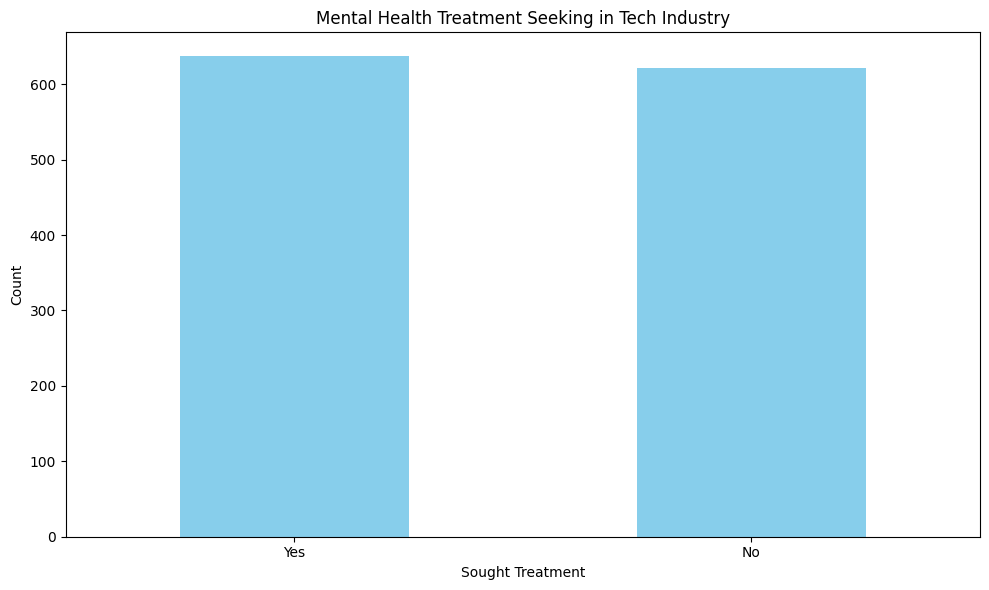

In [32]:
# Visualize treatment preferences from the tech survey dataset
treatment_counts = tech_survey_df['treatment'].value_counts()

plt.figure(figsize=(10, 6))
treatment_counts.plot(kind='bar', color='skyblue')
plt.title('Mental Health Treatment Seeking in Tech Industry')
plt.xlabel('Sought Treatment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

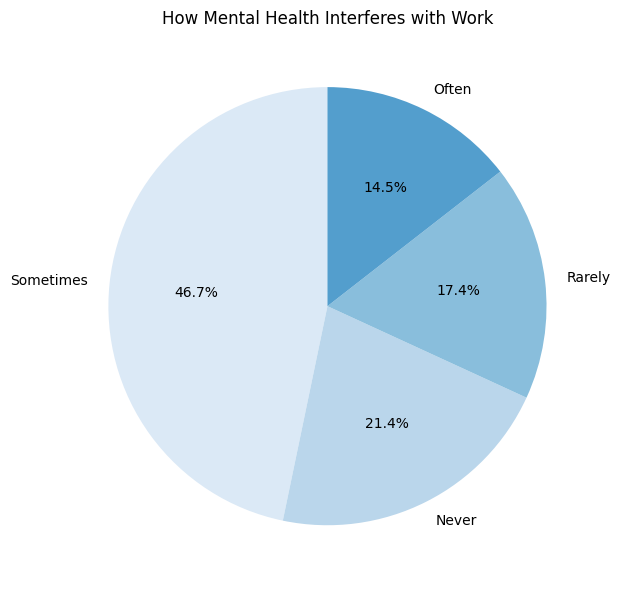

In [33]:
# Visualize how mental health interferes with work
work_interfere_counts = tech_survey_df['work_interfere'].value_counts()

plt.figure(figsize=(10, 6))
work_interfere_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Blues"))
plt.title('How Mental Health Interferes with Work')
plt.ylabel('')
plt.tight_layout()
plt.show()

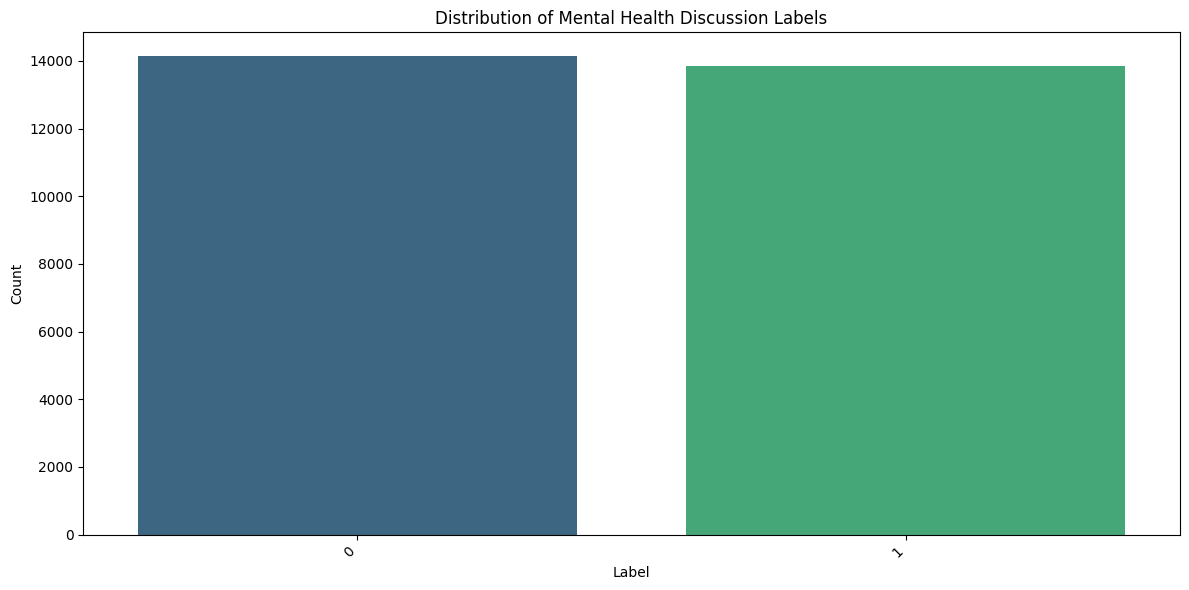

In [34]:
# Visualize labels from the mental health corpus
label_counts = mental_health_posts_df['label'].value_counts() # Use 'label' column

plt.figure(figsize=(12, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis") # Use label_counts
plt.title('Distribution of Mental Health Discussion Labels') # Updated title
plt.xlabel('Label') # Updated label
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Conclusion

In this project, we've developed a comprehensive Mental Health Text Analysis and Support System using Google Gemini API. The system demonstrates several key Gen AI capabilities:

1. **Structured Output/JSON Mode** - We used this to analyze and categorize mental health text data, identifying concerns, severity levels, and support needs.

2. **Retrieval Augmented Generation (RAG)** - We implemented a RAG system using the Gemini API for embeddings and ChromaDB to provide evidence-based mental health information from reliable sources.

3. **Few-Shot Prompting** - We used few-shot examples to improve the quality and appropriateness of mental health support responses.

4. **Long Context Window** - We leveraged Gemini's long context window to maintain coherent and supportive conversations over multiple exchanges.

5. **Document Understanding** - We demonstrated how Gemini can analyze and extract insights from mental health research literature.

### Potential Applications:

- **Preliminary screening tool** for mental health professionals
- **24/7 support companion** for individuals with mental health concerns
- **Research assistant** for mental health researchers analyzing text data
- **Training tool** for mental health support volunteers
- **Wellness resource** in workplace or educational settings

### Limitations and Ethical Considerations:

- This system is not a replacement for professional mental health care
- All analyses should be reviewed by qualified professionals
- Privacy and data security are critical for any real-world implementation
- Continuous monitoring and evaluation are necessary to ensure appropriate responses
- Cultural sensitivity and inclusivity must be considered in further development

### Future Directions:

- Integration with professional referral networks
- Development of specialized modules for different mental health conditions
- Enhanced privacy-preserving methods for sensitive data
- Multimodal capabilities (voice, image analysis)
- Personalization based on individual histories and preferences

This project demonstrates the potential of generative AI to support mental health care systems while acknowledging the important role of human professionals in providing care.